In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
# -*- coding:utf-8 -*-
import sys
import torch.nn as nn
import numpy as np
import os
import lmdb

# 基本深度学习网络结构

In [4]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ =self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)
        output = self.embedding(t_rec)
        output = output.view(T, b, -1)
        return output

In [5]:
class CRNN(nn.Module):
    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'

        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))

            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))

        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))  # 64x16x64
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))  # 128x8x32
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 256x4x16
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))  # 512x2x16
        convRelu(6, True)  # (conv6): Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1)) 以核为2做卷积 512x1x16 c*h*w

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)  # squeeze中的参数0、1分别代表第一、第二维度，squeeze(0)表示
                                # 如果第一维度值为1，则去掉，否则不变。故b的维度(1,3),可去掉1成(3),但
                                # 不可去掉3。
        conv = conv.permute(2, 0, 1)  # [w, b, c]

        # rnn features
        output = self.rnn(conv)

        return output

# 准备数据

In [43]:
# 生成测试Image
from PIL import Image, ImageDraw, ImageFont
import random

def genImage(label, fontsize, color=(0, 0, 0),fontName=u"simsunb.ttf"):

    print('label {} fontsize {}'.format(label, fontsize))
    
    img = Image.new("RGB", ((int)(fontsize/1.65 * len(label)), (int)(fontsize * 2)), (255, 255, 255))
    print(((int)(fontsize * len(label)), (int)(fontsize * 2)))
    font = ImageFont.truetype(fontName, fontsize)
    draw = ImageDraw.Draw(img)
    draw.text((5, 10), label, fill=color, font=font)
    with open("./data/dataline/" + label + "-" + str(fontsize) + ".txt", "w", encoding='utf-8') as f:
        f.write(label)
    img.save("./data/dataline/" + label + "-" + str(fontsize) + ".jpg")
    
    
alphabet = """'abcdefghijklmn1234567890.[]ABCDEFGHIJKLM"""
charact = alphabet[:]
textLen = len(charact) - 11
for i in range(500):
    ss = random.randint(0, textLen)
    genImage(alphabet[ss:ss + random.randint(6,15)], 24)



label 234567890 fontsize 24
(216, 48)
label hijklmn1234 fontsize 24
(264, 48)
label 567890.[ fontsize 24
(192, 48)
label bcdefghijklm fontsize 24
(288, 48)
label abcdefghijklmn fontsize 24
(336, 48)
label 7890.[] fontsize 24
(168, 48)
label []ABCD fontsize 24
(144, 48)
label 567890.[ fontsize 24
(192, 48)
label 4567890 fontsize 24
(168, 48)
label .[]ABC fontsize 24
(144, 48)
label mn1234567890.[] fontsize 24
(360, 48)
label defghi fontsize 24
(144, 48)
label 90.[]ABCDEF fontsize 24
(264, 48)
label 0.[]ABCDEFG fontsize 24
(264, 48)
label efghijkl fontsize 24
(192, 48)
label bcdefghij fontsize 24
(216, 48)
label klmn1234567890 fontsize 24
(336, 48)
label 567890.[ fontsize 24
(192, 48)
label klmn1234567 fontsize 24
(264, 48)
label 1234567890.[] fontsize 24
(312, 48)
label 7890.[]ABCD fontsize 24
(264, 48)
label 567890.[] fontsize 24
(216, 48)
label hijklmn1234567 fontsize 24
(336, 48)
label 'abcdefghijkl fontsize 24
(312, 48)
label 123456 fontsize 24
(144, 48)
label 345678 fontsize 24
(14

label bcdefghijklmn1 fontsize 24
(336, 48)
label 123456789 fontsize 24
(216, 48)
label ghijkl fontsize 24
(144, 48)
label defghijklmn123 fontsize 24
(336, 48)
label 'abcdef fontsize 24
(168, 48)
label 234567890.[] fontsize 24
(288, 48)
label fghijklmn123 fontsize 24
(288, 48)
label jklmn12345678 fontsize 24
(312, 48)
label cdefghij fontsize 24
(192, 48)
label cdefghijklmn fontsize 24
(288, 48)
label 2345678 fontsize 24
(168, 48)
label 34567890.[] fontsize 24
(264, 48)
label defghijkl fontsize 24
(216, 48)
label 890.[] fontsize 24
(144, 48)
label mn1234 fontsize 24
(144, 48)
label 1234567890.[] fontsize 24
(312, 48)
label bcdefghij fontsize 24
(216, 48)
label ghijklmn fontsize 24
(192, 48)
label 4567890.[]ABCDE fontsize 24
(360, 48)
label CDEFGHIJKLM fontsize 24
(264, 48)
label 34567890.[]A fontsize 24
(288, 48)
label []ABCDE fontsize 24
(168, 48)
label .[]ABCDEFGHIJKL fontsize 24
(360, 48)
label fghijklmn1234 fontsize 24
(312, 48)
label ABCDEFGHIJKLM fontsize 24
(312, 48)
label 2345678

label 7890.[]ABC fontsize 24
(240, 48)
label efghijklmn123 fontsize 24
(312, 48)
label jklmn1234567 fontsize 24
(288, 48)
label 1234567 fontsize 24
(168, 48)
label mn1234567890 fontsize 24
(288, 48)
label bcdefghijkl fontsize 24
(264, 48)
label 34567890.[] fontsize 24
(264, 48)
label 890.[]ABCDE fontsize 24
(264, 48)
label 7890.[]ABCDEF fontsize 24
(312, 48)
label 3456789 fontsize 24
(168, 48)
label hijklmn1234 fontsize 24
(264, 48)
label CDEFGHIJKLM fontsize 24
(264, 48)
label mn1234567 fontsize 24
(216, 48)
label lmn1234 fontsize 24
(168, 48)
label mn1234567890.[ fontsize 24
(336, 48)
label CDEFGHIJ fontsize 24
(192, 48)
label lmn123456 fontsize 24
(216, 48)
label 34567890. fontsize 24
(216, 48)
label 4567890.[]ABC fontsize 24
(312, 48)
label ]ABCDEFGH fontsize 24
(216, 48)
label defghijklmn123 fontsize 24
(336, 48)
label 4567890.[]ABCD fontsize 24
(336, 48)
label ijklmn fontsize 24
(144, 48)
label 890.[]A fontsize 24
(168, 48)
label 67890.[]ABC fontsize 24
(264, 48)
label ]ABCDE fon

    训练数据采用的是LMDB进行存储。
    
    LMDBCaffe使用LMDB来存放训练/测试用的数据集，以及使用网络提取出的feature（为了方便，以下还是统称数据集）。数据集的结构很简单，就是大量的矩阵/向量数据平铺开来。数据之间没有什么关联，数据内没有复杂的对象结构，就是向量和矩阵。既然数据并不复杂，Caffe就选择了LMDB这个简单的数据库来存放数据。

    LMDB的全称是Lightning Memory-Mapped Database，闪电般的内存映射数据库。它文件结构简单，一个文件夹，里面一个数据文件，一个锁文件。数据随意复制，随意传输。它的访问简单，不需要运行单独的数据库管理进程，只要在访问数据的代码里引用LMDB库，访问时给文件路径即可。

    图像数据集归根究底从图像文件而来。既然有ImageDataLayer可以直接读取图像文件，为什么还要用数据库来放数据集，增加读写的麻烦呢？我认为，Caffe引入数据库存放数据集，是为了减少IO开销。读取大量小文件的开销是非常大的，尤其是在机械硬盘上。LMDB的整个数据库放在一个文件里，避免了文件系统寻址的开销。LMDB使用内存映射的方式访问文件，使得文件内寻址的开销非常小，使用指针运算就能实现。数据库单文件还能减少数据集复制/传输过程的开销。一个几万，几十万文件的数据集，不管是直接复制，还是打包再解包，过程都无比漫长而痛苦。LMDB数据库只有一个文件，你的介质有多块，就能复制多快，不会因为文件多而慢如蜗牛。

In [44]:
# 创建数据库
# import lmdb  # install lmdb by "pip install lmdb"
# env = lmdb.open('./data/lmdb', map_size=511627776)
# env = lmdb.open('./data/lmdb', map_size=511627776)
# from genLineText import GenTextImage
def checkImageIsValid(imageBin):
    if imageBin is None:
        return False
    
    imageBuf = np.frombuffer(imageBin, dtype=np.uint8)
    img = cv2.imdecode(imageBuf, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return False
    imgH, imgW = img.shape[0], img.shape[1]
    if imgH * imgW == 0:
        return False
    return True

def writeCache(env, cache):
    with env.begin(write=True) as txn:
        for k, v in cache.items():
            txn.put(k.encode(), v)
            
            
def createDataset(outputPath, imagePathList, labelList, lexiconList=None, checkValid=True):
    """
    Create LMDB dataset for CRNN training.

    ARGS:
        outputPath    : LMDB output path
        imagePathList : list of image path
        labelList     : list of corresponding groundtruth texts
        lexiconList   : (optional) list of lexicon lists
        checkValid    : if true, check the validity of every image
    """
    # print (len(imagePathList) , len(labelList))
    assert (len(imagePathList) == len(labelList))
    nSamples = len(imagePathList)
    
    env = lmdb.open(outputPath, map_size=511627776)

    cache = {}
    cnt = 1
    for i in range(nSamples):
        imagePath = imagePathList[i]
        label = labelList[i]
        if not os.path.exists(imagePath):
            print('%s does not exist' % imagePath)
            continue
        with open(imagePath, 'rb') as f:
            imageBin = f.read()
        
        if checkValid:
            if not checkImageIsValid(imageBin):
                print('%s is not a valid image' % imagePath)
                continue

        imageKey = 'image-%09d' % cnt
        labelKey = 'label-%09d' % cnt
        cache[imageKey] = imageBin
        cache[labelKey] = label.encode()
        if lexiconList:
            lexiconKey = 'lexicon-%09d' % cnt
            cache[lexiconKey] = ' '.join(lexiconList[i]).encode()
        if cnt % 1000 == 0:
            writeCache(env, cache)
            cache = {}
            print('Written %d / %d' % (cnt, nSamples))
        cnt += 1
    nSamples = cnt - 1
    cache['num-samples'] = str(nSamples).encode()
    writeCache(env, cache)
    print('Created dataset with %d samples' % nSamples)


def read_text(path):
    with open(path) as f:
        text = f.read()
    text = text.strip()

    return text
            

In [46]:
import glob
import cv2

# outputPath = './data/lmdb/train'   # 训练数据
outputPath = './data/lmdb/test'   # 测试数据
path = './data/dataline/*.jpg'
imagePathList = glob.glob(path)
imgLabelLists = []
for p in imagePathList:
    try:
        imgLabelLists.append((p, read_text(p.replace('.jpg', '.txt'))))
    except:
        continue

imgLabelList = sorted(imgLabelLists, key=lambda x: len(x[1]))
imgPaths = [p[0] for p in imgLabelList]
txtLists = [p[1] for p in imgLabelList]

createDataset(outputPath, imgPaths, txtLists, lexiconList=None, checkValid=True)


Created dataset with 213 samples


In [42]:
import six
outputPath = './data/lmdb/train'
env = lmdb.open(outputPath)
txn = env.begin(write=False)
for key, value in txn.cursor():
    if 'label' in str(key):
         print(key, str(value))
# img_key = 'image-%09d' % 2
# imgbuf = txn.get(img_key.encode())

# buf = six.BytesIO()
# buf.write(imgbuf)
# buf.seek(0)
# try:
#     img = Image.open(buf).convert('L')
# #     img = Image.open(buf)
#     array = np.array(img)
#     print(len(array[array!=255]))
# except IOError:
#     print('Corrupted image for %d' % index)
env.close()

b'label-000000001' b"'abcde"
b'label-000000002' b'0.[]AB'
b'label-000000003' b'345678'
b'label-000000004' b'67890.'
b'label-000000005' b'7890.['
b'label-000000006' b'890.[]'
b'label-000000007' b'90.[]A'
b'label-000000008' b'abcdef'
b'label-000000009' b'bcdefg'
b'label-000000010' b'CDEFGH'
b'label-000000011' b'defghi'
b'label-000000012' b'efghij'
b'label-000000013' b'fghijk'
b'label-000000014' b'ghijkl'
b'label-000000015' b'hijklm'
b'label-000000016' b'ijklmn'
b'label-000000017' b'jklmn1'
b'label-000000018' b'klmn12'
b'label-000000019' b'lmn123'
b'label-000000020' b'mn1234'
b'label-000000021' b'n12345'
b'label-000000022' b"'abcdef"
b'label-000000023' b'2345678'
b'label-000000024' b'567890.'
b'label-000000025' b'67890.['
b'label-000000026' b'890.[]A'
b'label-000000027' b'90.[]AB'
b'label-000000028' b'abcdefg'
b'label-000000029' b'bcdefgh'
b'label-000000030' b'CDEFGHI'
b'label-000000031' b'defghij'
b'label-000000032' b'efghijk'
b'label-000000033' b'hijklmn'
b'label-000000034' b'ijklmn1'
b

# 训练网络

    https://blog.csdn.net/dcrmg/article/details/80199722
    
    CTC可以生成一个损失函数，用于在序列数据上进行监督式学习，不需要对齐输入数据及标签，经常连接在一个RNN网络的末端，训练端到端的语音和文本识别系统。CTC论文地址： http://www.cs.toronto.edu/%7Egraves/icml_2006.pdf
    
    CTC：前向计算 https://zhuanlan.zhihu.com/p/23293860  ， 来自百度的warp-ctc， 暂时不支付win环境 
    我们定义T为RNN输出的结果的维数，这个问题的最终输出维度为alphabet_size。而ground_truth的维数为L。也就是说，RNN输出的结果为alphabet_size*T的结果，我们要将这个结果和1*L这个向量进行对比，求出最终的Loss。
    


In [ ]:
import torch.backends.cudnn as cudnn
import torch.optim as optim
from warpctc_pytorch import CTCLoss


# alphabet = alphabet = u'\'疗绚诚娇溜题贿者廖更纳加....'   基本词库表
converter = utils.strLabelConverter(alphabet)  # 调用方法生成字典：         self.dict = {}
                                                #for i, char in enumerate(alphabet):
                                                    # NOTE: 0 is reserved for 'blank' required by wrap_ctc
                                                    # self.dict[char] = i + 1
criterion = CTCLoss()

# custom weights initialization called on crnn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# 创建网络模型, 并初始化参数
crnn = crnn.CRNN(opt.imgH, nc, nclass, nh, ngpu)
crnn.apply(weights_init)

# 每次训练的大小，初始化图片高度、宽度
image = torch.FloatTensor(opt.batchSize, 3, opt.imgH, opt.imgH)
text = torch.IntTensor(opt.batchSize * 5)
length = torch.IntTensor(opt.batchSize)

image = Variable(image)
text = Variable(text)
length = Variable(length)

# loss averager  平均数
loss_avg = utils.averager()

optimizer = optim.RMSprop(crnn.parameters(), lr=opt.lr)


# 批训练方法
def trainBatch(net, criterion, optimizer, flage=False):
    data = train_iter.next()
    cpu_images, cpu_texts = data  ##decode utf-8 to unicode
    if ifUnicode:    # python 3 以后应该不需要该处理方式
        cpu_texts = [clean_txt(tx) for tx in cpu_texts]

    batch_size = cpu_images.size(0)
    utils.loadData(image, cpu_images)    # 将cpu images 数据复制到image
    t, l = converter.encode(cpu_texts)   # 返回text 里面 char对应的编码及cpu_texts 总长度
    utils.loadData(text, t)              # 复制数据到text
    utils.loadData(length, l)

    preds = crnn(image)
    preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
    cost = criterion(preds, text, preds_size, length) / batch_size
    crnn.zero_grad()
    cost.backward()
    if flage:
        lr = 0.0001
        optimizer = optim.Adadelta(crnn.parameters(), lr=lr)
    optimizer.step()
    return cost


numLoss = 0  ##判断训练参数是否下降
# loss averager
loss_avg = utils.averager()

for epoch in range(opt.niter):
    train_iter = iter(train_loader)
    i = 0
    while i < len(train_loader):
        # print('The step{} ........\n'.format(i))
        for p in crnn.parameters():
            p.requires_grad = True
        crnn.train()
        # if numLoss>50:
        #    cost = trainBatch(crnn, criterion, optimizer,True)
        #    numLoss = 0
        # else:
        cost = trainBatch(crnn, criterion, optimizer)
        loss_avg.add(cost)
        i += 1

        # if i % opt.displayInterval == 0:
        #    print('[%d/%d][%d/%d] Loss: %f' %
        #          (epoch, opt.niter, i, len(train_loader), loss_avg.val()))
        #    loss_avg.reset()

        if i % opt.valInterval == 0:
            testLoss, accuracy = val(crnn, test_dataset, criterion)
            # print('Test loss: %f, accuray: %f' % (testLoss, accuracy))
            print("epoch:{},step:{},Test loss:{},accuracy:{},train loss:{}".
                  format(epoch, num, testLoss, accuracy, loss_avg.val()))
            loss_avg.reset()
            print('Save model to:', opt.experiment)
            torch.save(crnn.state_dict(), '{}/netCRNN.pth'.format(
                opt.experiment))
        # do checkpointing
        num += 1
        # lasttestLoss = min(lasttestLoss,testLoss)

        if lasttestLoss > testLoss:
            print("The step {},last lost:{}, current: {},save model!".format(
                num, lasttestLoss, testLoss))
            lasttestLoss = testLoss
            # delete(opt.experiment)##删除历史模型
            torch.save(crnn.state_dict(), '{}/netCRNN.pth'.format(
                opt.experiment))
            numLoss = 0
        else:
            numLoss += 1



# warp-CTC  
    https://blog.csdn.net/dcrmg/article/details/80199722
    https://blog.csdn.net/yifen4234/article/details/80334516
    https://blog.csdn.net/xmdxcsj/article/details/51763886
    https://distill.pub/2017/ctc/ 
    
    https://blog.csdn.net/JackyTintin/article/details/79425866   【Learning Notes】CTC 原理及实现

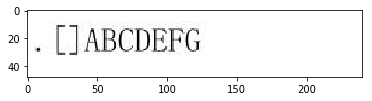

1686


In [24]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open('d:\\5.jpg').convert('L')
plt.imshow(image,'brg')
plt.show()
a = np.array(image)
print(len(a[a!=255]))



In [5]:
import torch
from torch.autograd import Variable
from warpctc_pytorch import CTCLoss
ctc_loss = CTCLoss()
# expected shape of seqLength x batchSize x alphabet_size
probs = torch.FloatTensor([[[0.1, 0.6, 0.1, 0.1, 0.1], [0.1, 0.1, 0.6, 0.1, 0.1]]]).transpose(0, 1).contiguous()
labels = Variable(torch.IntTensor([1, 2]))
label_sizes = Variable(torch.IntTensor([2]))
probs_sizes = Variable(torch.IntTensor([2]))

probs = Variable(probs, requires_grad=True) # tells autograd to compute gradients for probs
print(probs.size())
print(labels.size())
print(probs_sizes.size())
print(label_sizes.size())
cost = ctc_loss(probs, labels, probs_sizes, label_sizes)
print(cost)
cost.backward()

torch.Size([2, 1, 5])
torch.Size([2])
torch.Size([1])
torch.Size([1])
tensor([2.4629], grad_fn=<_CTCBackward>)
